In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Average, Conv2D, Dense, Flatten, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.metrics import AUC
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
meta = pd.read_csv('../processed_data/train.csv', index_col=0)
meta.head()

,target,IP_0001230,IP_0019713,IP_0036322,IP_0038436,IP_0038545,IP_0039318,IP_0041255,IP_0045462,IP_0046310,...,IP_9997715,Unknown,female,male,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


### Metadata

In [3]:
y = meta['target'].values.reshape(-1,1)
X = meta.drop('target', axis=1)
meta_train, meta_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=867_5309)

In [4]:
meta_train = meta_train.astype('ushort')
meta_test = meta_test.astype('ushort')

In [5]:
meta_train.shape

(23188, 2065)

In [6]:
y_train.shape

(23188, 1)

### Image data

In [7]:
PATH = '../processed_data/train_img_array.pkl'
with open(PATH, 'rb') as file:
    img_array = pickle.load(file)
img_array = img_array.astype('ushort')
img_train, img_test, _1, _2 = train_test_split(img_array, y, test_size=0.3, random_state=867_5309) # Should split exactly the same as above

In [8]:
img_train.shape

(23188, 80, 120, 3)

In [9]:
img_test.shape

(9938, 80, 120, 3)

### Model

This model will utilize the functional Keras API to produce a mixed model.

In [10]:
# Define inputs
meta_inputs = Input(shape=(2065,))
img_inputs = Input(shape=(80,120,3,))

# Model 1
meta_layer1 = Dense(16, activation='relu')(meta_inputs)
meta_output_layer = Dense(1, activation='sigmoid')(meta_layer1)

# Model 2
padding_layer = ZeroPadding2D(padding=(1,1))(img_inputs)
img_conv_layer1 = Conv2D(4, kernel_size=(3,3), padding='same', activation='relu')(padding_layer)
img_pooling_layer1 = MaxPooling2D(padding='same')(img_conv_layer1)
img_conv_layer2 = Conv2D(8, kernel_size=(5,5), padding='same', activation='relu')(img_pooling_layer1)
img_pooling_layer2 = MaxPooling2D(padding='same')(img_conv_layer2)
img_gap_layer = GlobalAveragePooling2D()(img_pooling_layer2)
img_dense_layer = Dense(256, activation='relu')(img_gap_layer)
img_output_layer = Dense(1, activation='sigmoid')(img_dense_layer)

# Merge models
merged = Concatenate()([meta_output_layer, img_output_layer])


# Define functional model
model = Model(inputs=[meta_inputs, img_inputs], outputs=merged)

# Compile model
auc = AUC(name = 'auc')
model.compile('adam', loss='binary_crossentropy', metrics=[auc])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 120, 3)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 82, 122, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 82, 122, 4)   112         zero_padding2d[0][0]             
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 41, 61, 4)    0           conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
epochs = 15
history = model.fit([meta_train, img_train], y_train, epochs=epochs, batch_size=500, validation_data=([meta_test, img_test], y_test))

Epoch 1/15
47/47 [==============================] - 8s 76ms/step - loss: 0.4047 - auc: 0.5148 - val_loss: 0.2353 - val_auc: 0.6675
Epoch 2/15
47/47 [==============================] - 2s 50ms/step - loss: 0.2175 - auc: 0.6555 - val_loss: 0.1633 - val_auc: 0.7230
Epoch 3/15
47/47 [==============================] - 2s 50ms/step - loss: 0.1473 - auc: 0.7616 - val_loss: 0.1159 - val_auc: 0.7437
Epoch 4/15
47/47 [==============================] - 2s 50ms/step - loss: 0.1117 - auc: 0.8646 - val_loss: 0.0947 - val_auc: 0.7628
Epoch 5/15
47/47 [==============================] - 2s 50ms/step - loss: 0.0920 - auc: 0.8963 - val_loss: 0.0867 - val_auc: 0.7524
Epoch 6/15
47/47 [==============================] - 2s 50ms/step - loss: 0.0819 - auc: 0.9186 - val_loss: 0.0838 - val_auc: 0.7423
Epoch 7/15
47/47 [==============================] - 2s 50ms/step - loss: 0.0789 - auc: 0.9275 - val_loss: 0.0827 - val_auc: 0.7457
Epoch 8/15
47/47 [==============================] - 2s 50ms/step - loss: 0.0781 - a

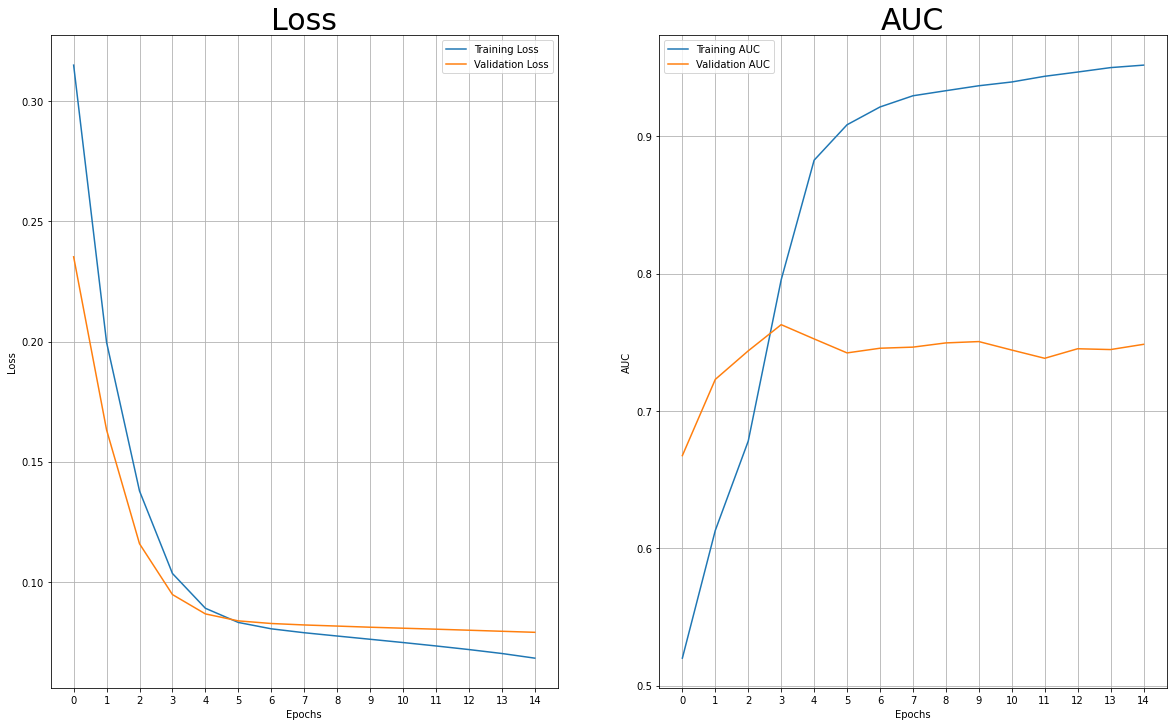

In [12]:
X = np.arange(0, epochs)

plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(X, history.history['loss'], label = 'Training Loss')
plt.plot(X, history.history['val_loss'], label = 'Validation Loss')
plt.grid(True)
plt.xticks(X)
plt.legend()
plt.title('Loss', fontsize=30)

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.plot(X, history.history['auc'], label = 'Training AUC')
plt.plot(X, history.history['val_auc'], label = 'Validation AUC')
plt.grid(True)
plt.xticks(X)
plt.legend()
_ = plt.title('AUC', fontsize=30)

There is a great deal of overfitting in this model.